## Update the metadata for integrated Visium object

In [1]:
import sys 
import os
from datetime import datetime
date = datetime.now().strftime("%Y-%m-%d")
import pandas as pd
import numpy as np
import scanpy as sc
import anndata as ad
import hdf5plugin

# Import key analysis packages
import scvi


# Define repo path and add it to sys path (allows to access scripts and metadata from repo)
repo_path = '/nfs/team205/vk8/projects/thymus_ageing_atlas/Spatial_analyses'
sys.path.insert(1, repo_path) 
sys.path.insert(2, '/nfs/team205/vk8/projects/thymus_ageing_atlas/General_analysis/scripts')


/nfs/team205/vk8/mambaforge/envs/scvi-env3/lib/python3.12/site-packages/docrep/decorators.py:43: SyntaxWarning: 'param_categorical_covariate_keys' is not a valid key!
  doc = func(self, args[0].__doc__, *args[1:], **kwargs)
/nfs/team205/vk8/mambaforge/envs/scvi-env3/lib/python3.12/site-packages/docrep/decorators.py:43: SyntaxWarning: 'param_continuous_covariate_keys' is not a valid key!
  doc = func(self, args[0].__doc__, *args[1:], **kwargs)


In [2]:
# Define paths for plot and path dirs
plot_path = os.path.join(repo_path, 'plots')
data_path = os.path.join(repo_path, 'data')
results_path = os.path.join(repo_path, 'results')
model_path = os.path.join(repo_path, 'models')
general_data_path = '/nfs/team205/vk8/projects/thymus_ageing_atlas/General_analysis/data'

In [3]:
# Set pandas display options
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all" # to show output from all the lines in a cells
pd.set_option('display.max_column',None) # display all the columns in pandas
pd.options.display.max_rows = 100

In [4]:
%load_ext autoreload
%autoreload 2
# Import custom scripts
from utils import get_latest_version,update_obs,freq_by_donor
from anno_levels import get_ct_levels, get_ct_palette, age_group_levels, age_group_palette
#from plotting.utils import plot_grouped_boxplot, calc_figsize

In [5]:
# Set plot formatting
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import font_manager
from matplotlib import rcParams
font_manager.fontManager.addfont("/nfs/team205/ny1/ThymusSpatialAtlas/software/Arial.ttf")
rcParams['pdf.fonttype'] = 42 # enables correct plotting of text

In [6]:
sc.settings.set_figure_params(dpi = 80, color_map = 'RdPu', dpi_save=300)
#plt.style.use('/nfs/team205/vk8/projects/thymus_ageing_atlas/General_analysis/scripts/plotting/thyAgeing.mplstyle')

In [7]:
def select_slide(adata, s, s_col='SampleID'):
    r""" This function selects the data for one slide from the spatial anndata object.

    :param adata: Anndata object with multiple spatial experiments
    :param s: name of selected experiment
    :param s_col: column in adata.obs listing experiment name for each location
    """

    slide = adata[adata.obs[s_col].isin([s]), :]
    s_keys = list(slide.uns['spatial'].keys())
    s_spatial = np.array(s_keys)[[s in k for k in s_keys]][0]

    slide.uns['spatial'] = {s_spatial: slide.uns['spatial'][s_spatial]}

    return slide

## Load combined Visium object

In [8]:
adata_vis = ad.read_h5ad(f"{data_path}/thyAgeing_allVisium_OCT_FFPE_integrated_v2_filt_2025-09-25.zarr")

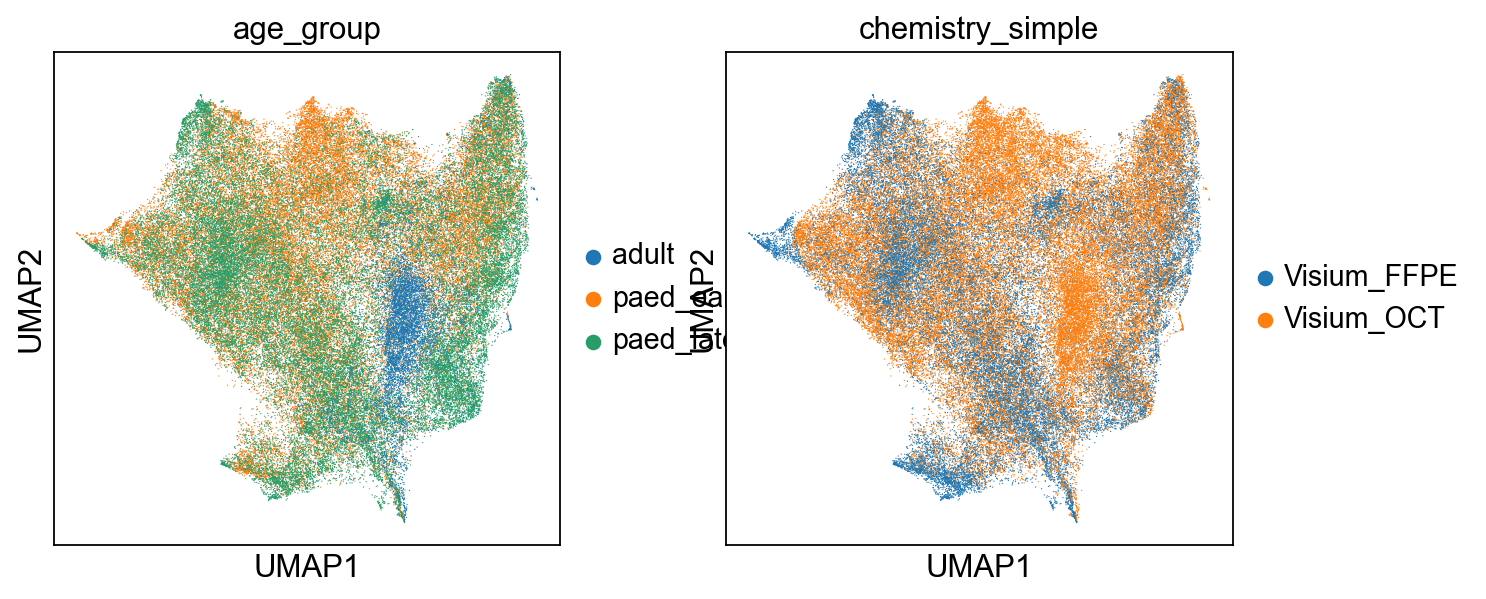

In [9]:
sc.pl.umap(adata_vis, color = ['age_group', 'chemistry_simple'])

## Add histological annotations

In [10]:
objs = [f'{results_path}/ThyAge_Visium_epaed_OCT_annos_merged_2025-09-14.csv', 
       f'{results_path}/ThyAge_Visium_OCT_FFPE_annos_v2_merged_2025-10-23.csv', 
       f'{results_path}/ThyAge_Visium_aged_OCTannos_merged_2025-09-26.csv']

In [12]:
anno_df_list = []
for obj in objs:
    df = pd.read_csv(obj, index_col = 0)
    anno_df_list.append(df)

anno_df_full = pd.concat(anno_df_list, axis = 0)

In [25]:
anno_df_full.to_csv(f'{results_path}/ThyAge_Visium_epaed_lpaed_aged_merged_2025-10-23.csv', index = True)

In [13]:
adata_vis.obs.drop(columns = [ '1', '2', '3', '4',
       '5', 'pxl_row_in_fullres', 'pxl_col_in_fullres', 'x', 'y',
       'L2_dist_annotations_cma_Artifacts', 'L2_dist_annotations_cma_Cortex',
       'L2_dist_annotations_cma_Edge', 'L2_dist_annotations_cma_Medulla',
       'L2_dist_annotations_cma_unassigned', 'L2_dist_annotations_level_1_HS',
       'L2_dist_annotations_level_1_PVS',
       'L2_dist_annotations_level_1_unassigned',
       'L2_dist_annotations_level_1_vessels', 'annotations_cma',
       'annotations_level_0', 'annotations_level_0_number',
       'annotations_level_1', 'annotations_level_1_number', 'cma_2p', 'cma_3p',
       'L2_dist_annotations_level_1_fat', 'manual_bin_cma_3p',
       'manual_bin_cma_3p_int', 'annotations_v1', 'annotations_v1_number',
       'in_tissue', 'array_row', 'array_col', 'L2_dist_annotations_cma_PVS',
       'L2_dist_annotations_cma_fibrotic', 'annotations_v2',
       'annotations_v2_number', 'L2_dist_annotations_cma_fat',
       'L2_dist_annotations_cma_Adipose', 'L2_dist_annotations_cma_Fibrosis',
       'L2_dist_annotations_cma_HCs', 'L2_dist_annotations_cma_Vessels',
       'annotations_full'], inplace = True)

In [14]:
adata_vis.obs = adata_vis.obs.merge(anno_df_full, left_index = True, right_index = True, how = 'left').copy()

In [15]:
adata_vis.obs['annotations_legacy'] = adata_vis.obs.apply(lambda x: x['annotations_level_1'] if ((x['age_group'] == 'paed_early') & (x['chemistry_simple'] == 'Visium_OCT')) & (x['annotations_level_1']!='unassigned') else
                                                                    x['annotations_level_0'] if (x['age_group'] == 'paed_early') & (x['chemistry_simple'] == 'Visium_OCT') 
                                                          else 'None', axis = 1)

adata_vis.obs['annotations_legacy'] = adata_vis.obs['annotations_legacy'].astype('category')

adata_vis.obs['annotations_legacy'] = adata_vis.obs['annotations_legacy'].cat.rename_categories(['Cortex', 'Edge', 'HCs', 'Medulla', 'None', 'interloPVS', 'Adipose', 'Vessels']).copy()

In [16]:
adata_vis.obs['annotations_legacy'].value_counts()

annotations_legacy
None          59274
Cortex        19958
Medulla        7729
Edge           3117
interloPVS      329
HCs             273
Adipose          15
Vessels           4
Name: count, dtype: int64

In [17]:
adata_vis.obs['annotations_v2_cor'] = adata_vis.obs['annotations_v2'].apply(lambda x: 'Adipose' if x == 'fat' else
                                                                           'Fibrosis' if x == 'fibrotic' else
                                                                            'intraloPVS' if x == 'PVS' else
                                                                           'HCs' if x == 'HC' else x)

In [18]:
adata_vis.obs['annotations_v2_cor'].value_counts()

annotations_v2_cor
Cortex        21091
Medulla       13874
Edge           7453
Adipose        4846
intraloPVS     3660
HCs             496
Fibrosis        315
Vessels          14
Name: count, dtype: int64

In [19]:
adata_vis.obs['annotations_full'] = adata_vis.obs.apply(lambda x: x['annotations_legacy'] if (x['age_group'] == 'paed_early') & (x['chemistry_simple'] == 'Visium_OCT') else
                                                        x['annotations_v2_cor'], axis = 1)

In [20]:
pd.crosstab(adata_vis.obs['age_group'], adata_vis.obs['annotations_full'])

annotations_full  Adipose  Cortex  Edge  Fibrosis  HCs  Medulla  Vessels  \
age_group                                                                  
adult                4293     190     0       312   32     1484       14   
paed_early             16   23856  4588         0  369     9458        4   
paed_late             552   17003  5982         3  368    10661        0   

annotations_full  interloPVS  intraloPVS  
age_group                                 
adult                      0           0  
paed_early               329         508  
paed_late                  0        3152

In [21]:
adata_vis.obs['annotations_cma_full'] = adata_vis.obs.apply(lambda x: 'Adipose' if x['annotations_cma'] == 'fat' else
                                                            'Fibrosis' if x['annotations_cma'] == 'fibrotic' else
                                                             'None' if x['age_group'] == 'adult' else
                                                            x['annotations_cma'], axis = 1) 

In [22]:
pd.crosstab(adata_vis.obs['age_group'], adata_vis.obs['annotations_cma_full'])

annotations_cma_full  Adipose  Cortex  Edge  Fibrosis  Medulla  None   PVS
age_group                                                                 
adult                       0       0     0         0        0  6858     0
paed_early                  1   23924  4711         0     9984     0   508
paed_late                 552   17003  5982         3    11029     0  3152

In [23]:
sum(adata_vis.obs['annotations_cma_full'].isnull())

13089

In [24]:
sum(adata_vis.obs['annotations_full'].isnull())

13622

In [25]:
adata_vis_filt = adata_vis[~adata_vis.obs['annotations_full'].isnull(),].copy()

In [26]:
adata_vis_filt.shape

(83174, 18085)

In [27]:
adata_vis_filt

AnnData object with n_obs × n_vars = 83174 × 18085
    obs: 'in_tissue_x', 'array_row_x', 'array_col_x', 'SampleID', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'percent_mito', 'Sample', 'Sample_hr', 'Path', 'donor', 'donor_type', 'age_group', 'age_misc', 'age_numeric', 'age_months', 'Sex', 'Source', 'SlideID', 'Position', 'section_thickness(um)', 'permebialisation(min)', 'RIN/DV200', 'Block', 'Block_type', 'chemistry_simple', 'chemistry_detail', 'Probeset', 'Number of genes', 'Study', 'Study_name', 'published', 'QC', 'Batch', 'RawData', 'Sequencer', 'Spaceranger', 'reference', 'annotation_path', 'annotation_version', 'annotator', '5quant_outlier', 'vis-leiden_r0.6', 'vis-leiden_r0.8', 'vis-leiden_r1', '1', '2', '3', '4', '5', 'pxl_row_in_fullres', 'pxl_col_in_fullres', 'x', 'y', 'L2_dist_annotations_cma_Artifacts', 'L2_dist_annotations_cma_Cortex', 'L2_dist_annotations_cma_Edge', 'L2_dist_annotations_cma_Medulla', 'L2_dist_annotations_cma_unas

In [29]:
from utils_vk8 import regen_embed

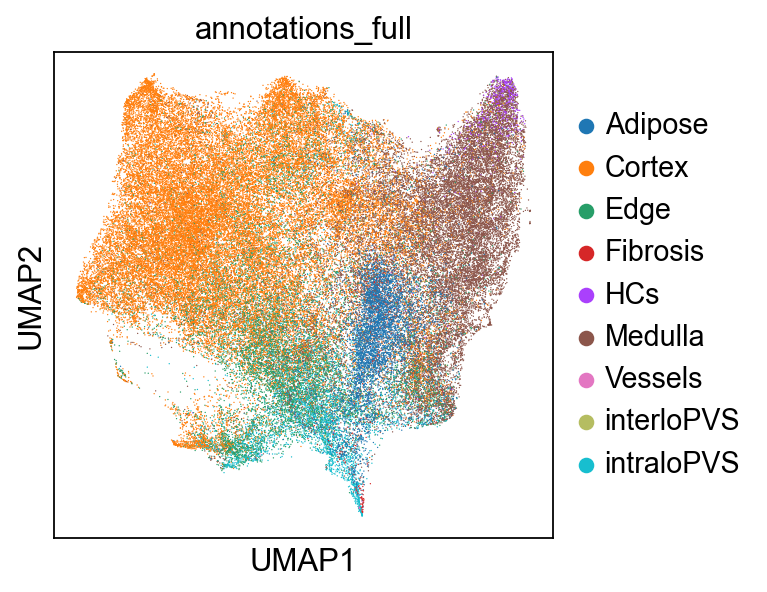

AnnData object with n_obs × n_vars = 83174 × 18085
    obs: 'in_tissue_x', 'array_row_x', 'array_col_x', 'SampleID', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'percent_mito', 'Sample', 'Sample_hr', 'Path', 'donor', 'donor_type', 'age_group', 'age_misc', 'age_numeric', 'age_months', 'Sex', 'Source', 'SlideID', 'Position', 'section_thickness(um)', 'permebialisation(min)', 'RIN/DV200', 'Block', 'Block_type', 'chemistry_simple', 'chemistry_detail', 'Probeset', 'Number of genes', 'Study', 'Study_name', 'published', 'QC', 'Batch', 'RawData', 'Sequencer', 'Spaceranger', 'reference', 'annotation_path', 'annotation_version', 'annotator', '5quant_outlier', 'vis-leiden_r0.6', 'vis-leiden_r0.8', 'vis-leiden_r1', '1', '2', '3', '4', '5', 'pxl_row_in_fullres', 'pxl_col_in_fullres', 'x', 'y', 'L2_dist_annotations_cma_Artifacts', 'L2_dist_annotations_cma_Cortex', 'L2_dist_annotations_cma_Edge', 'L2_dist_annotations_cma_Medulla', 'L2_dist_annotations_cma_unas

In [31]:
regen_embed(adata_vis_filt, 'annotations_full')

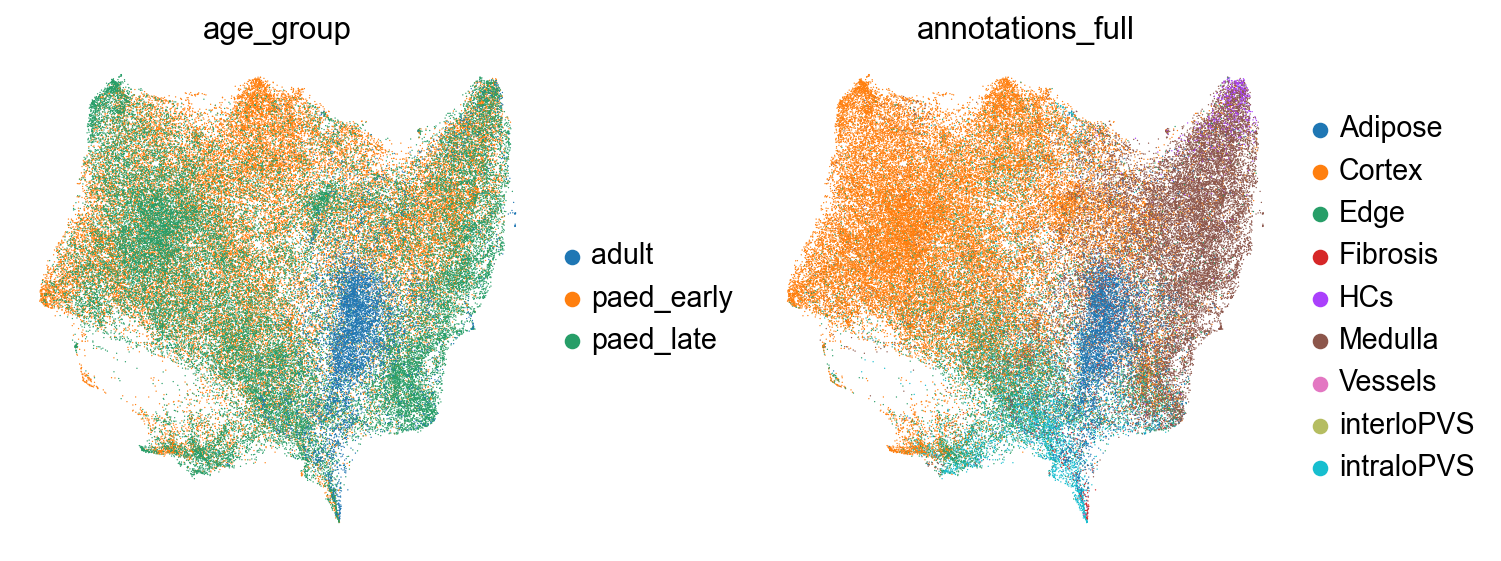

In [32]:
sc.pl.umap(adata_vis_filt, color = ['age_group', 'annotations_full'], ncols = 2, wspace = 0.3, frameon = False)

In [33]:
adata_vis_filt.obs['annotations_full'] = adata_vis_filt.obs['annotations_full'].cat.reorder_categories(['Edge','Cortex','Medulla','HCs', 'interloPVS', 'intraloPVS','Vessels',
                                                               'Fibrosis', 'Adipose']).copy()

In [34]:
areas_color_dict = {'Edge': '#1f77b4', 
               'Cortex': '#A0CBE8',
                'Medulla': '#ff7f0e',
                   'HCs': '#d62728',
                   'interloPVS': '#59A14F',
                    'intraloPVS':'#E75480',
                'Vessels': '#8c564b',
                'Fibrosis': "#B07AA1",
                'Adipose': "#FFC000"}

In [35]:
areas_color_dict.values()

dict_values(['#1f77b4', '#A0CBE8', '#ff7f0e', '#d62728', '#59A14F', '#E75480', '#8c564b', '#B07AA1', '#FFC000'])

In [36]:
adata_vis_filt.uns['annotations_full_colors'] = ['#1f77b4', '#A0CBE8', '#ff7f0e', '#d62728', '#59A14F', '#E75480', '#8c564b', '#B07AA1', '#FFC000']

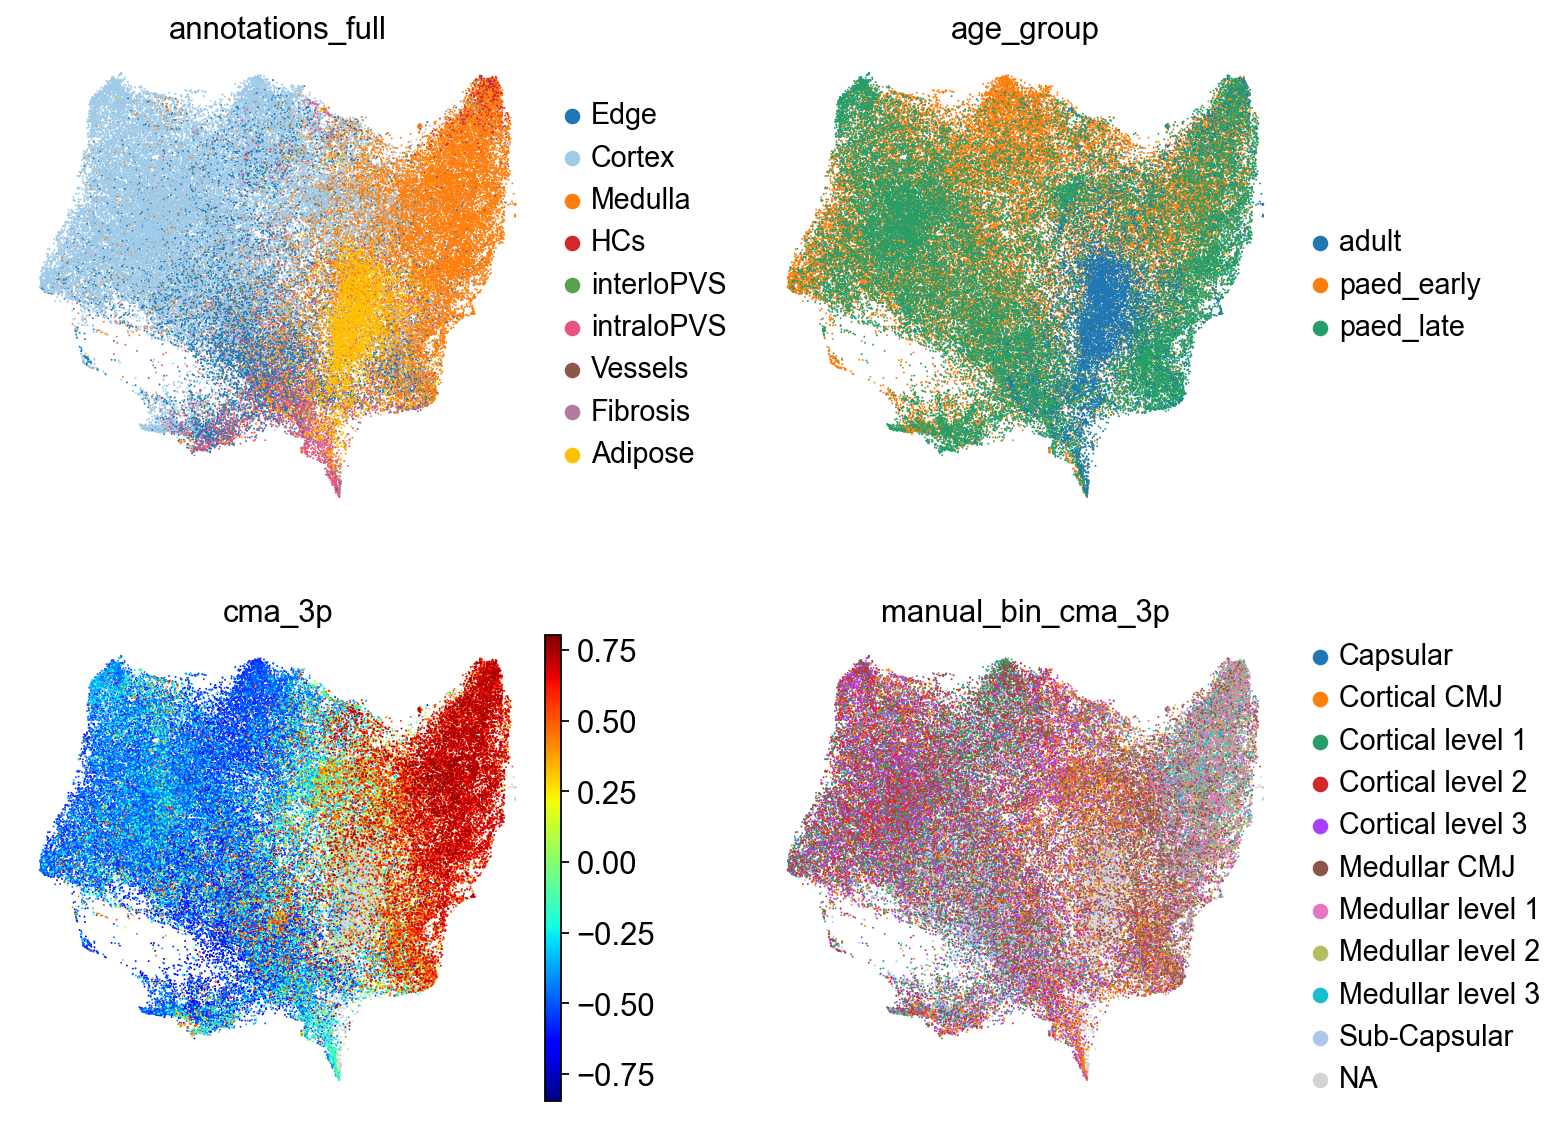

In [37]:
sc.pl.umap(adata_vis_filt, color = ['annotations_full', 'age_group', 'cma_3p', 'manual_bin_cma_3p'], 
           ncols = 2, wspace = 0.3, frameon = False, size = 3, return_fig = True, cmap = 'jet').savefig(f'{plot_path}/ThyAge_Visium_OCT_FFPE_filt_integ_UMAPsbio_v2.pdf', dpi = 300)

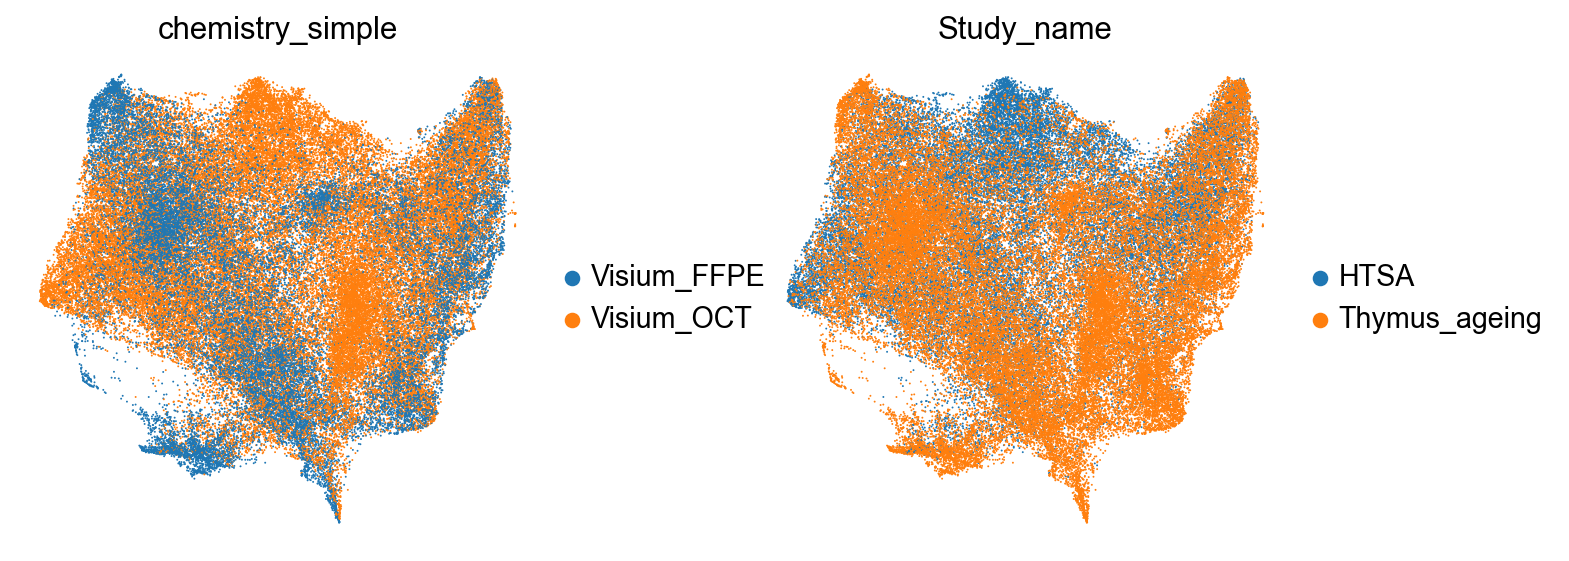

In [38]:
sc.pl.umap(adata_vis_filt, color = ['chemistry_simple', 'Study_name'], 
           ncols = 2, wspace = 0.3, frameon = False, size = 3, return_fig = True).savefig(f'{plot_path}/ThyAge_Visium_OCT_FFPE_filt_integ_UMAPstech2_v2.pdf', dpi = 300)

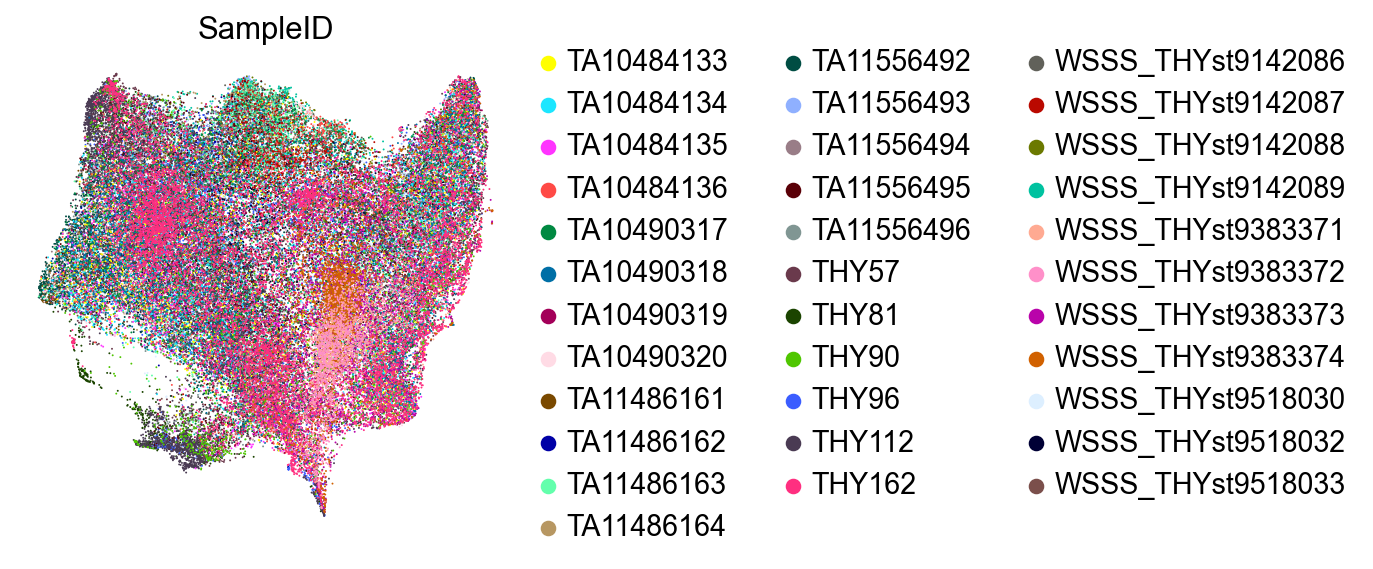

In [39]:
sc.pl.umap(adata_vis_filt, color = ['SampleID'], 
           ncols = 2, wspace = 0.3, frameon = False, size = 3, return_fig = True).savefig(f'{plot_path}/ThyAge_Visium_OCT_FFPE_filt_integ_UMAP2sample_v2.pdf', dpi = 300)

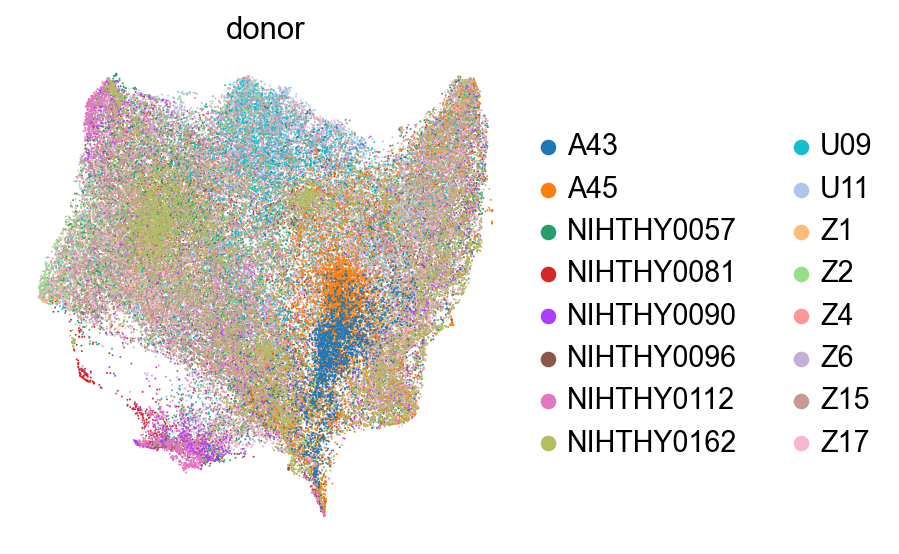

In [40]:
sc.pl.umap(adata_vis_filt, color = ['donor'], 
           ncols = 2, wspace = 0.3, frameon = False, size = 3, return_fig = True).savefig(f'{plot_path}/ThyAge_Visium_OCT_FFPE_filt_integ_UMAP2donor_v2.pdf', dpi = 300)

## Save the object

In [56]:
today = datetime.now().strftime('%Y-%m-%d')
adata_vis_filt.write_h5ad(f'{data_path}/thyAgeing_allVisium_OCT_FFPE_integrated_v3_filt_{today}.zarr', compression=hdf5plugin.FILTERS["zstd"],
                     compression_opts=hdf5plugin.Zstd(clevel=5).filter_options)